## Install Desired Libraries

In [1]:
%pip install peft==0.4.0 datasets transformers rouge_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=8bddf76ff9df38638d7756f2890fc02990c609823beb61b92e92994542b3c11b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


## Install Desired Libraries

In [17]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import transformers
from peft import LoraConfig, get_peft_model
from transformers import GPT2Tokenizer
from rouge_score import rouge_scorer
import torch
from peft import PeftModel
import time
from transformers import EarlyStoppingCallback
from transformers import DataCollatorForLanguageModeling


## Load the Model and the Dataset

In [3]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

data = load_dataset("cnn_dailymail", "3.0.0")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
tokenizer.pad_token = tokenizer.eos_token
print(data)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [5]:
train_data = data['train']
test_data = data['test']
validation_data=data['validation']


train_size = int(0.01 * len(train_data))
test_size = int(0.01 * len(test_data))
validation_size = int(0.01 * len(validation_data))

train_sample = train_data.select(range(train_size))
test_sample = test_data.select(range(test_size))
validation_sample = validation_data.select(range(validation_size))

In [6]:
print(len(train_sample))
print(len(test_sample))
print(len(validation_sample))

2871
114
133


In [7]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["article"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data_train =train_sample.map(preprocess_function, batched=True)
tokenized_data_test =test_sample.map(preprocess_function, batched=True)
tokenized_data_validation =validation_sample.map(preprocess_function, batched=True)

Map:   0%|          | 0/2871 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

## Declare the LORA Configuration

In [11]:
lora_config = LoraConfig(
    r=4,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor for the LoRA update
    target_modules=["c_attn"],  # The attention layer to apply LoRA
    lora_dropout=0.1,  # Dropout applied to the LoRA layers
    bias="none",  # Not training the bias terms
    task_type="CAUSAL_LM"  # Language modeling task
)

In [12]:
peft_model = get_peft_model(foundation_model, lora_config)

total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 124587264
Trainable parameters: 147456


In [29]:
peft_model.add_adapter(peft_config=lora_config, adapter_name="t2")

In [34]:
# Define the output directory where the fine-tuned model will be saved.
output_directory = "./peft_gpt2_finetuned_model"
start_time=time.time()

# Define the training arguments.
training_args = TrainingArguments(
    output_dir=output_directory,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none",
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_validation,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)



In [36]:
peft_model.save_pretrained(output_directory)


In [37]:
# Start training the LoRA-adapted GPT-2 model.
trainer.train()
test_results = trainer.evaluate(tokenized_data_test)

# Print the evaluation results, which include loss
print("Test results:", test_results)

Step,Training Loss,Validation Loss
100,3.006200,3.063350
200,2.991200,3.063392
300,3.042200,3.062808
400,3.043000,3.059238
500,2.999000,3.058566
600,2.993900,3.059060
700,3.011700,3.058182
800,2.971500,3.058044
900,3.023700,3.058718
1000,2.988300,3.057764


Test results: {'eval_loss': 3.009855270385742}


In [38]:
end_time=time.time()
print("Time taken", end_time-start_time)

Time taken 922.0464434623718


In [40]:
# Evaluation Loss and ROUGE Scoring
def compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = [scorer.score(ref, pred) for ref, pred in zip(refs, preds)]
    avg_scores = {k: sum([score[k].fmeasure for score in scores]) / len(scores) for k in scores[0]}
    return avg_scores

# Generate Predictions for ROUGE Evaluation
def evaluate_model():
    eval_loss = trainer.evaluate()['eval_loss']
    print(f"Evaluation Loss: {eval_loss}")

    test_preds = []
    test_refs = [example["highlights"] for example in test_sample]

    # Ensure peft_model LoRA layers are active during generation
    peft_model.eval()  # Set the model to evaluation mode
    for example in tokenized_data_test:
        inputs = torch.tensor(example["input_ids"]).unsqueeze(0).to(peft_model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(peft_model.device)

        with torch.no_grad():
            outputs = peft_model.base_model.generate(
                inputs,
                attention_mask=attention_mask,
                max_length=513,
                pad_token_id=tokenizer.eos_token_id
            )
        test_preds.append(tokenizer.decode(outputs[0][:128], skip_special_tokens=True))

    rouge_scores = compute_rouge(test_preds, test_refs)
    print("ROUGE Scores:", rouge_scores)

# Run the evaluation
evaluate_model()

Step,Training Loss,Validation Loss
100,3.006200,3.063350
200,2.991200,3.063392
300,3.042200,3.062808
400,3.043000,3.059238
500,2.999000,3.058566
600,2.993900,3.059060
700,3.011700,3.058182
800,2.971500,3.058044
900,3.023700,3.058718
1000,2.988300,3.057764


Evaluation Loss: 3.056145429611206
ROUGE Scores: {'rouge1': 0.28211328834260735, 'rouge2': 0.12021106998130526, 'rougeL': 0.19454699563574615}


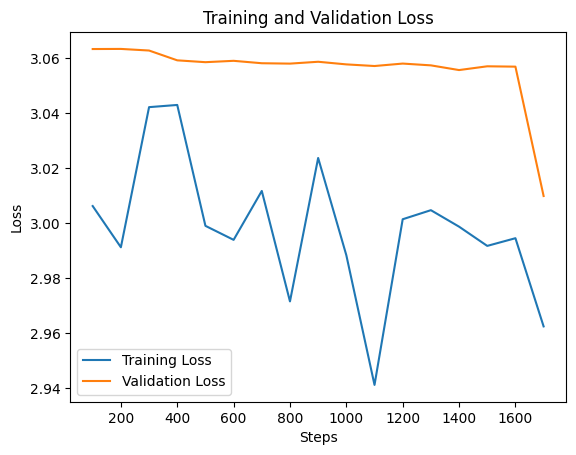

In [1]:
import matplotlib.pyplot as plt

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700]

training_loss = [3.006200, 2.991200, 3.042200, 3.043000, 2.999000, 2.993900, 3.011700, 2.971500, 3.023700, 2.988300, 2.941100, 3.001400, 3.004700, 2.998700, 2.991700, 2.994500, 2.962400]

validation_loss = [3.063350, 3.063392, 3.062808, 3.059238, 3.058566, 3.059060, 3.058182, 3.058044, 3.058718, 3.057764, 3.057168, 3.058060, 3.057409, 3.055697, 3.057067, 3.056940, 3.009855]

# Plot the training and validation loss
plt.plot(steps, training_loss, label="Training Loss")
plt.plot(steps, validation_loss, label="Validation Loss")

# Set the plot title and labels
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Display the plot
plt.show()